In [9]:
import sys
sys.path.append('../src')
from evaluation import  eval_results, get_noiseless_name, get_ambient_name

In [4]:
import wandb
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
import numpy as np
import os
import glob
import demap
from transformations import NonTransform

specific to @xingzhis' model: load data names from config. 

In [11]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'wgysuau8'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]
run = sweep.runs[0] # for example.
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
try:
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
except:
    print(f"No checkpoint found for run {run.id}")
cfg = OmegaConf.create(run.config)

data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
noiseless_path = os.path.join(cfg.data.root, get_noiseless_name(cfg.data.name) + cfg.data.filetype)

Specific to @xingzhis' model: load model

In [12]:
pp = NonTransform()
emb_dim = cfg.model.emb_dim
dist_std = 1.
input_dim = 100
model = make_model(cfg, input_dim, emb_dim, pp, dist_std, from_checkpoint=True, checkpoint_path=ckpt_path)

compute metric

In [5]:
# result = eval_results(data_path, noiseless_path, model)

In [6]:
# result

In [13]:
import magic

In [14]:
from evaluation import get_dataset_contents

In [17]:
from random import seed
x_test, x_noiseless, dist_true, _ = get_dataset_contents(data_path, noiseless_path)

In [18]:
import torch
x_tensor = torch.from_numpy(x_test).float().to(model.device)
model.eval()
z_pred = model.encode(x_tensor)
x_pred = model.decode(z_pred)
z_pred = z_pred.detach().cpu().numpy()
x_pred = x_pred.detach().cpu().numpy()

In [19]:
magic_op = magic.MAGIC()
# we probably wouldn't run MAGIC on reconstructed data because it is already denoised.
# X_recon_magic = magic_op.fit_transform(X_reconstructed)
X_recon_magic = x_pred
X_real_magic = magic_op.fit_transform(x_test)
# Compute column wise correlations within each matrix
corrs_recon = np.corrcoef(X_recon_magic, rowvar=False) # vars (genes) are in columns
corrs_real = np.corrcoef(X_real_magic, rowvar=False)
# get mse


Calculating MAGIC...
  Running MAGIC on 400 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating imputation...
Calculated MAGIC in 0.08 seconds.


In [20]:
mse = np.mean(np.square(corrs_recon - corrs_real))
mse

0.15660691086450965

In [21]:
corrs_noisy = np.corrcoef(x_test, rowvar=False) # vars (genes) are in columns

In [22]:
np.mean(np.square(corrs_recon - corrs_noisy))

0.07904860344934153

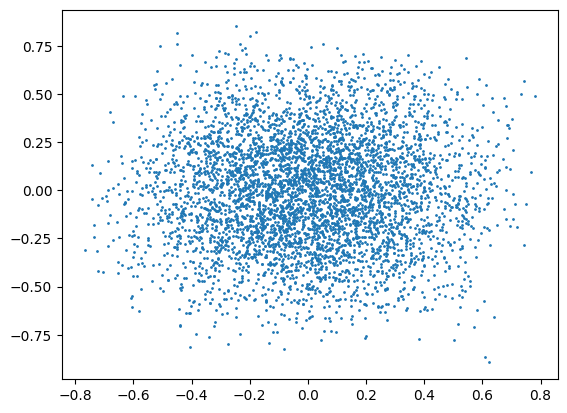

In [27]:
triu_id = np.triu_indices(corrs_noisy.shape[0], k=1)
plt.scatter(corrs_recon[triu_id], corrs_real[triu_id], s=1)

In [23]:
np.mean(np.square(corrs_real - corrs_noisy))

0.07927342445573002

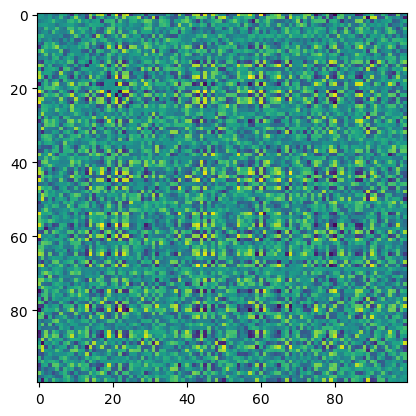

In [30]:
plt.imshow(corrs_real - corrs_noisy)

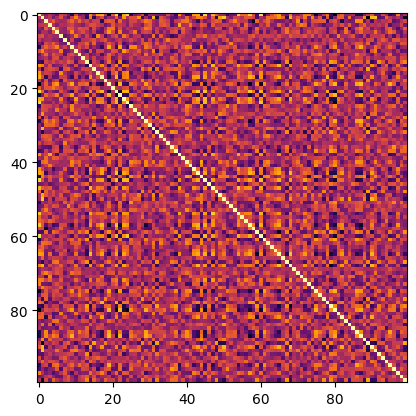

In [16]:
plt.imshow(corrs_real, cmap='inferno')

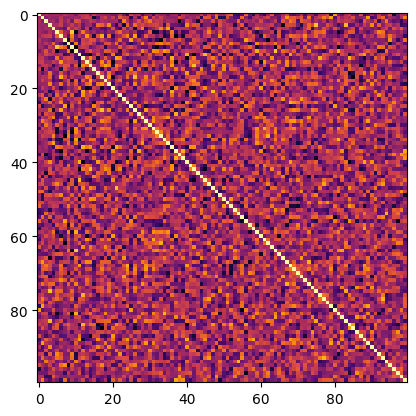

In [17]:
plt.imshow(corrs_recon, cmap='inferno')

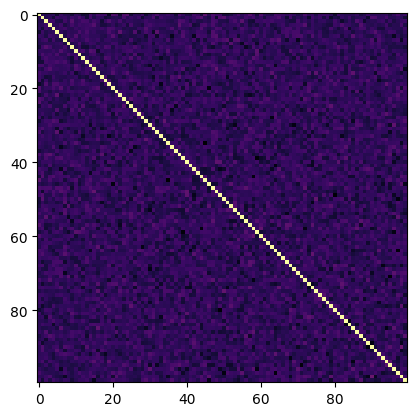

In [19]:
plt.imshow(corrs_noisy, cmap='inferno')

In [26]:
corrs_noiseless = np.corrcoef(x_noiseless, rowvar=False)

In [31]:
from scipy.stats import spearmanr
sprcorrs_recon = spearmanr(x_pred, axis=0).correlation
sprcorrs_noisy = spearmanr(x_test, axis=0).correlation
sprcorrs_real = spearmanr(X_real_magic, axis=0).correlation
sprcorrs_noiseless = spearmanr(x_noiseless, axis=0).correlation

In [55]:
np.mean(np.square(sprcorrs_recon - sprcorrs_noiseless))

0.07477209250155768

In [54]:
np.mean(np.square(sprcorrs_noiseless - sprcorrs_real))

0.07834943989167835

In [56]:
np.mean(np.square(sprcorrs_noiseless - sprcorrs_noisy))

0.004387843046296583

In [42]:
spearmanr(sprcorrs_recon.flatten(), sprcorrs_real.flatten()).correlation

0.08104752424878678

In [41]:
spearmanr(sprcorrs_real.flatten(), sprcorrs_noisy.flatten()).correlation

0.2869782062287428

In [36]:
spearmanr(corrs_recon.flatten(), corrs_real.flatten()).correlation

0.04591056010321347

In [ ]:
spearmanr(sprcorrs_recon.flatten(), sprcorrs_real.flatten()).correlation

In [27]:
np.m(np.square(corrs_noiseless - corrs_noisy))

44.76737303558055

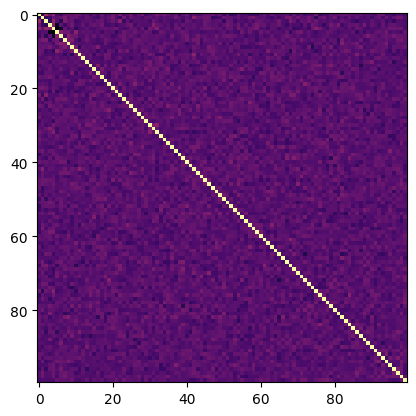

In [43]:
plt.imshow(sprcorrs_noiseless, cmap='inferno')

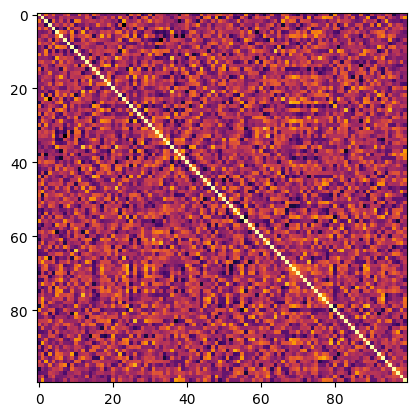

In [30]:
plt.imshow(sprcorrs_recon, cmap='inferno')

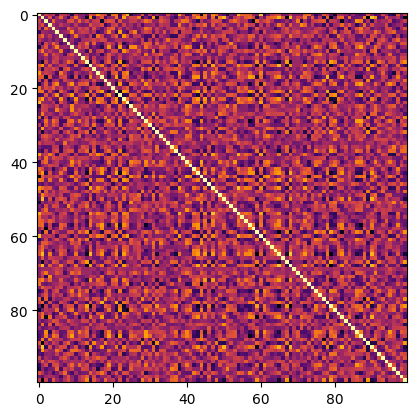

In [32]:
plt.imshow(sprcorrs_real, cmap='inferno')

In [48]:
idx = np.triu_indices(len(sprcorrs_real), k=1)
sprrealtriu = sprcorrs_real[idx]
sprrecontriu = sprcorrs_recon[idx]
sprrnoisytriu = sprcorrs_noisy[idx]

In [47]:
spearmanr(sprrealtriu, sprrecontriu).correlation

0.05291919509829482

In [49]:
spearmanr(sprrealtriu, sprrnoisytriu).correlation

0.265153234598703

In [50]:
(np.square(X_real_magic - x_noiseless)).mean()

2.183782461880489

In [68]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [60]:
mean_absolute_percentage_error(sprcorrs_real, sprcorrs_recon)

11.574163333262593

In [64]:
mean_absolute_percentage_error(sprcorrs_noisy, sprcorrs_recon)

33.560039124462236

In [62]:
mean_absolute_percentage_error(sprcorrs_real, sprcorrs_noisy)

2.1512699887249593

In [65]:
mean_absolute_percentage_error(sprcorrs_noiseless, sprcorrs_recon)

22.892196989138778

In [66]:
mean_absolute_percentage_error(sprcorrs_noiseless, sprcorrs_noisy)

6.039496031558821

In [67]:
mean_absolute_percentage_error(sprcorrs_noiseless, sprcorrs_real)

25.555755887153765

In [69]:
mean_squared_error(x_test, x_pred)

4.775622986693848

In [70]:
x_pred.var()

0.76343024

In [71]:
x_test.var()

5.5353086972911125

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes3D: >

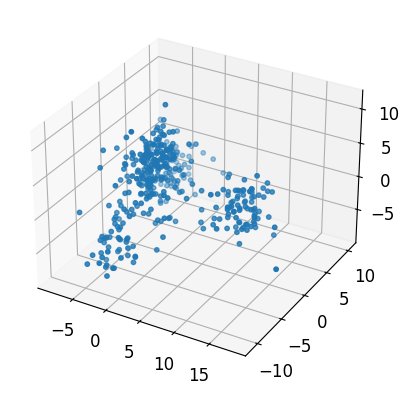

In [72]:
scprep.plot.scatter3d(x_test)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes3D: >

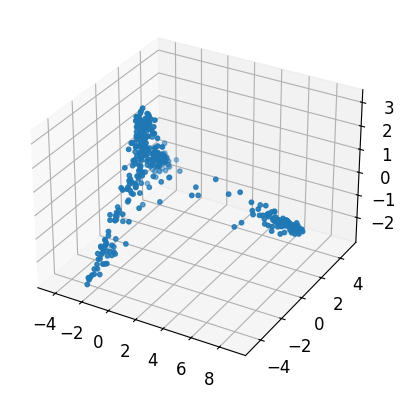

In [75]:
scprep.plot.scatter3d(X_real_magic)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes3D: >

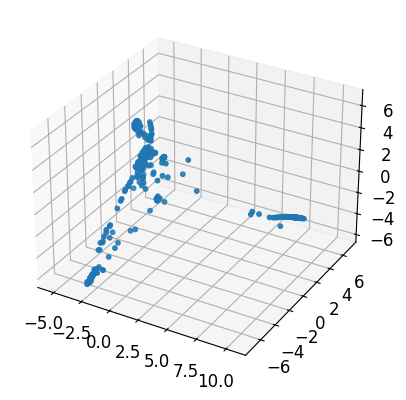

In [73]:
scprep.plot.scatter3d(x_pred)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes3D: >

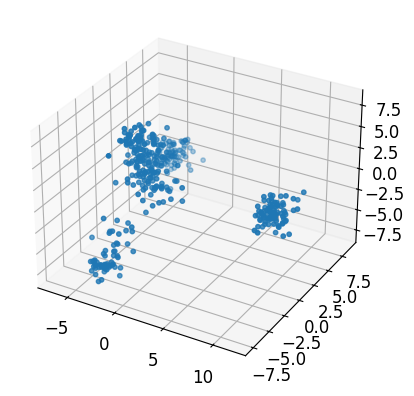

In [93]:
scprep.plot.scatter3d(x_noiseless)

In [79]:
x_pred.shape

(400, 100)

In [80]:
X_real_magic.shape

(400, 100)

In [23]:
import numpy as np
from scipy.stats import spearmanr, rankdata

def spearman_correlation_loop(A, B):
    """
    Compute the Spearman correlation for each corresponding column of matrices A and B using a loop.
    """
    assert A.shape == B.shape, "Matrices A and B must have the same size"
    correlations = []
    for i in range(A.shape[1]):
        corr, _ = spearmanr(A[:, i], B[:, i])
        correlations.append(corr)
    return np.array(correlations)

In [87]:
corrs = spearman_correlation_loop(X_real_magic, x_pred)

In [92]:
corrs.shape

(100,)

(array([1., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 2., 2., 3., 2., 2.,
        4., 1., 2., 2., 2., 1., 2., 1., 0., 2., 1., 0., 1., 3., 1., 4., 3.,
        4., 1., 6., 1., 4., 2., 2., 2., 0., 1., 3., 1., 0., 5., 1., 0., 0.,
        1., 2., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 2., 2., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]),
 array([-0.54799692, -0.533261  , -0.51852507, -0.50378915, -0.48905322,
        -0.4743173 , -0.45958137, -0.44484545, -0.43010952, -0.4153736 ,
        -0.40063767, -0.38590175, -0.37116582, -0.3564299 , -0.34169397,
        -0.32695805, -0.31222212, -0.2974862 , -0.28275027, -0.26801435,
        -0.25327842, -0.2385425 , -0.22380657, -0.20907064, -0.19433472,
        -0.17959879, -0.16486287, -0.15012694, -0.13539102, -0.12065509,
        -0.10591917, -0.09118324, -0.07644732, -0.06171139, -0.04697547,
        -0.03223954, -0.01750362, -0.00

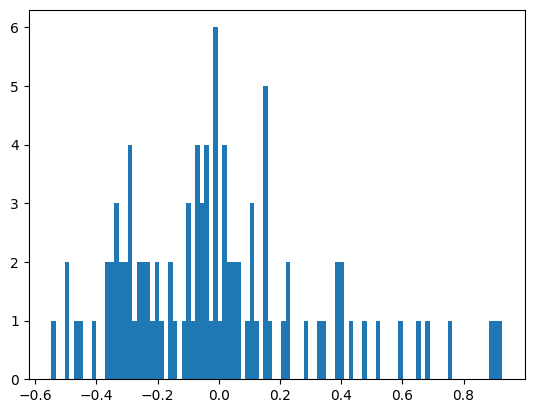

In [91]:
plt.hist(corrs, 100)

In [96]:
corrs[:10].mean()

0.6519229745185908

In [101]:
n = 10
mean_squared_error(sprcorrs_recon[:n,:][:,:n], sprcorrs_real[:n,:][:,:n])

0.07283558912238723

In [102]:
n = 100
mean_squared_error(sprcorrs_recon[:n,:][:,:n], sprcorrs_real[:n,:][:,:n])

0.1411500852676968

In [104]:
mean_squared_error(sprcorrs_recon, sprcorrs_real)

0.1411500852676968

Text(0, 0.5, 'Spearman R between magic and recon')

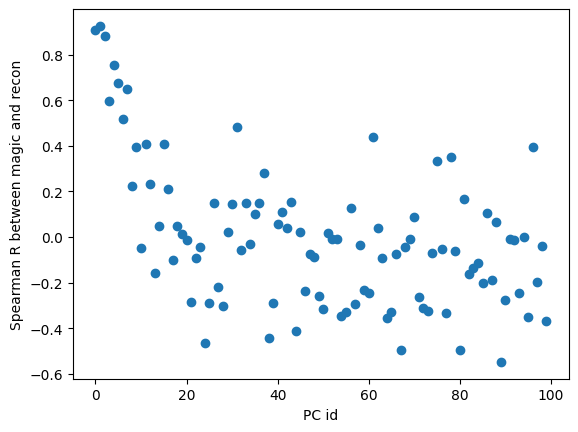

In [118]:
plt.scatter(np.arange(len(corrs)), corrs)
plt.xlabel('PC id')
plt.ylabel('Spearman R between magic and recon')

In [110]:
n = 10
mean_squared_error(X_real_magic[:,:n], x_pred[:,:n])

2.1546712887799084

In [111]:
n = 100
mean_squared_error(X_real_magic[:,:n], x_pred[:,:n])

0.29714932051786136

In [112]:
n = 1
mean_squared_error(X_real_magic[:,:n], x_pred[:,:n])

2.2937776313839504

In [116]:
corrs[:n]

array([0.90593066])

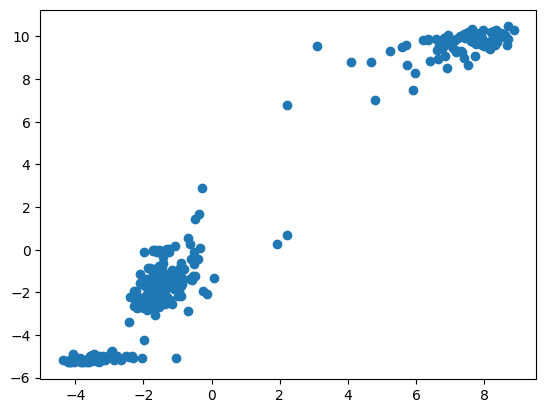

In [113]:
plt.scatter(X_real_magic[:,0], x_pred[:,0])

Text(0, 0.5, 'variance')

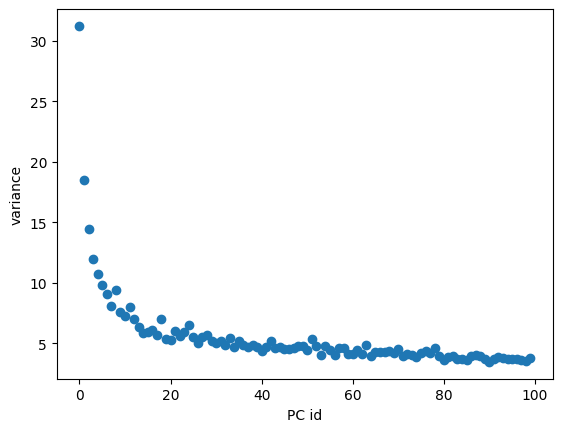

In [134]:
plt.scatter(np.arange(x_test.shape[1]), x_test.var(axis=0))
plt.xlabel('PC id')
plt.ylabel('variance')

Text(0, 0.5, 'Reconstruction MSE')

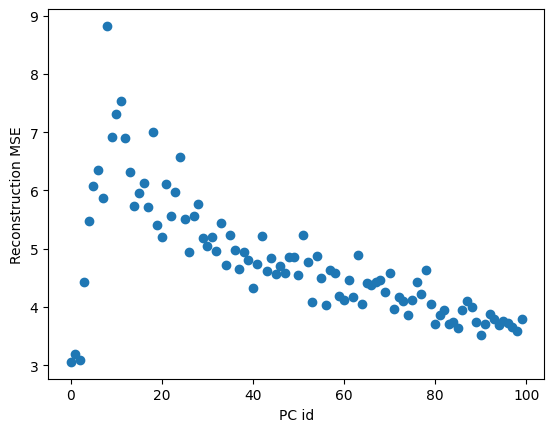

In [133]:
plt.scatter(np.arange(x_test.shape[1]), ((x_test - x_pred)**2).mean(axis=0))
plt.xlabel('PC id')
plt.ylabel('Reconstruction MSE')

Text(0, 0.5, 'vs MAGIC MSE')

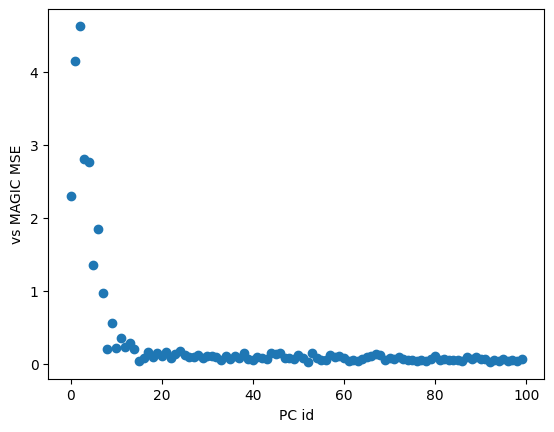

In [136]:
plt.scatter(np.arange(x_test.shape[1]), ((X_real_magic - x_pred)**2).mean(axis=0))
plt.xlabel('PC id')
plt.ylabel('vs MAGIC MSE')

In [12]:
data_path2 = os.path.join('../synthetic_data2', cfg.data.name + cfg.data.filetype)
noiseless_path2 = os.path.join('../synthetic_data2', rename_string(cfg.data.name) + cfg.data.filetype)

In [13]:
cfg.data.name

'noisy_46_groups_17580_2000_3_0.2_0.7_all'

In [14]:
data_raw_noisy = np.load(os.path.join('../synthetic_data2', 'nopc_'+ cfg.data.name[:-4] + '.npy'))

In [30]:
data_noisy_npz = np.load(os.path.join('../synthetic_data2', cfg.data.name+ '.npz'))

In [15]:
data_raw_noisy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca_transform_noisy = PCA(n_components=100)
data_noisy_pc = pca_transform_noisy.fit_transform(data_raw_noisy)

In [18]:
x_pred_ambient = pca_transform_noisy.inverse_transform(x_pred)

In [19]:
x_magic_ambient = pca_transform_noisy.inverse_transform(X_real_magic)

In [20]:
x_pred_ambient

array([[0.02984784, 0.09969208, 0.02771283, ..., 0.04385263, 0.0309972 ,
        0.0290236 ],
       [0.02806873, 0.0992068 , 0.02895008, ..., 0.04401112, 0.0298112 ,
        0.02567472],
       [0.04364833, 0.11560056, 0.03866103, ..., 0.02327184, 0.04676466,
        0.03416658],
       ...,
       [0.03345796, 0.08406206, 0.05154974, ..., 0.05878137, 0.01296419,
        0.05407951],
       [0.02887067, 0.09974263, 0.02800416, ..., 0.04381939, 0.03053984,
        0.02769559],
       [0.03432943, 0.09322196, 0.04374704, ..., 0.06053432, 0.02179537,
        0.06348163]])

In [21]:
x_magic_ambient

array([[0.03446404, 0.08976463, 0.03543618, ..., 0.04042652, 0.02551592,
        0.04261772],
       [0.02929473, 0.08581867, 0.03824703, ..., 0.04035858, 0.02402378,
        0.03433406],
       [0.04423013, 0.09795785, 0.03291015, ..., 0.04164313, 0.02994077,
        0.05340513],
       ...,
       [0.03920294, 0.10754041, 0.03607712, ..., 0.04859245, 0.02042747,
        0.05412687],
       [0.02804987, 0.088241  , 0.03484089, ..., 0.04233891, 0.02463864,
        0.03532206],
       [0.02527143, 0.09747622, 0.03473752, ..., 0.06553   , 0.0175244 ,
        0.0628105 ]])

In [36]:
x_pca_ambient = pca_transform_noisy.inverse_transform(x_test)

In [24]:
corrs_ambient = spearman_correlation_loop(x_magic_ambient, x_pred_ambient)

In [25]:
corrs_ambient.mean()

0.5836759622879042

In [43]:
corrs_ambient2 = spearman_correlation_loop(x_pca_ambient, x_magic_ambient)

(array([2.000e+00, 8.000e+00, 7.600e+01, 1.810e+02, 4.750e+02, 1.081e+03,
        2.220e+03, 4.491e+03, 6.430e+03, 2.616e+03]),
 array([-0.58712823, -0.4363652 , -0.28560216, -0.13483912,  0.01592391,
         0.16668695,  0.31744998,  0.46821302,  0.61897606,  0.76973909,
         0.92050213]),
 <BarContainer object of 10 artists>)

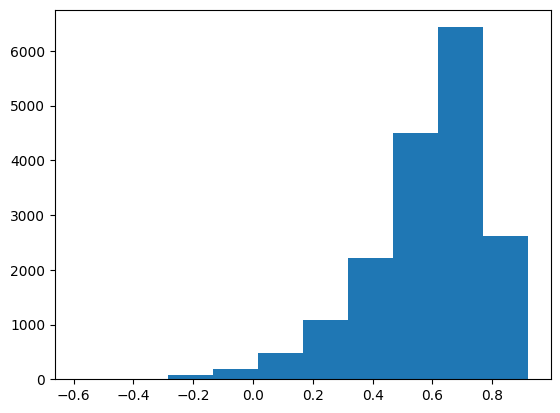

In [41]:
plt.hist(corrs_ambient)

(array([1.530e+02, 1.556e+03, 4.787e+03, 5.566e+03, 3.416e+03, 1.513e+03,
        4.770e+02, 9.900e+01, 1.100e+01, 2.000e+00]),
 array([0.37397577, 0.41496559, 0.45595541, 0.49694523, 0.53793505,
        0.57892487, 0.61991469, 0.66090451, 0.70189432, 0.74288414,
        0.78387396]),
 <BarContainer object of 10 artists>)

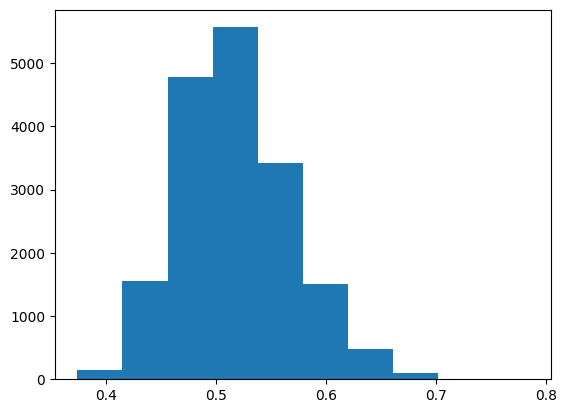

In [45]:
plt.hist(corrs_ambient2)

In [46]:
def pearson_correlation_corresponding(A, B):
    """
    Compute the Spearman correlation for each corresponding column of matrices A and B using a loop.
    """
    assert A.shape == B.shape, "Matrices A and B must have the same size"
    correlations = []
    for i in range(A.shape[1]):
        corr = np.corrcoef(A[:, i], B[:, i])[0,1]
        correlations.append(corr)
    return np.array(correlations)

In [47]:
pearcorrs_ambient = pearson_correlation_corresponding(x_magic_ambient, x_pred_ambient)

In [48]:
pearcorrs_ambient.mean()

0.6250571731585197

In [50]:
pearcorrs_ambient2 = pearson_correlation_corresponding(x_magic_ambient, x_pca_ambient)

In [51]:
pearcorrs_ambient2.mean()

0.510528214481263